# Определение перспективного тарифа для телеком-компании
    
<b>Цель проекта: </b> определить, какой тариф приносит больше денег: smart или ultra
        
<b>Имеющиеся данные: </b>
- данные по 500 пользователям
- данные с описанием тарифных пакетов
- данные по звонкам пользователей
- данные по отправленным пользователями сообщениям
- данные по использованному пользователями трафику

<b>План работы: </b>
- загрузить и изучить данные
- исправить ошибки в данных, если таковые есть
- создать единую сводную таблицу по активности пользователей и условиям тарифов
- провести анализ данных по звонкам, смс и трафику пользователей в зависимости от их тарифа, описать распределения
- проверить гипотезу о равенстве выручки тарифов
- проверить гипотезу о равенстве выручки пользователей из Москвы и регионов

## Загрузка и первичный анализ данных

### Импорт модулей и билиотек

In [351]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

### Загрузка данных

In [352]:
data_calls = pd.read_csv('/datasets/calls.csv')
data_internet = pd.read_csv('/datasets/internet.csv')
data_messages = pd.read_csv('/datasets/messages.csv')
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_users = pd.read_csv('/datasets/users.csv')

### Первичный взгляд на данные

In [353]:
data_list = [data_calls, data_internet, data_messages, data_tariffs, data_users]
for data in data_list:
    print(data.shape)
    display(data.sample(2))  

(202607, 4)


,id,call_date,duration,user_id
150315,1377_1162,2018-06-29,22.52,1377
114641,1293_57,2018-09-14,0.00,1293


(149396, 5)


,Unnamed: 0,id,mb_used,session_date,user_id
113166,113166,1382_159,603.08,2018-04-08,1382
119524,119524,1403_79,161.52,2018-06-09,1403


(123036, 3)


,id,message_date,user_id
94306,1385_1015,2018-05-12,1385
21958,1092_239,2018-12-05,1092


(2, 8)


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


(500, 8)


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
119,1119,53,NaN,Петрозаводск,Олег,Сухарев,2018-04-22,smart
238,1238,57,NaN,Ростов-на-Дону,Радислав,Наумов,2018-01-08,smart


<b>ВЫВОД:</b> количество признаков варьируется от 4 до 8, в таблице с интернетом выявлен лишний столбец, дублирующий индексы. Удалим лишний столбец, переименуем tariff в tariff_name для удобства и проверим дубликаты и пропуски.

In [354]:
# удалим ненужный столбец в данных с трафиком
data_internet.drop('Unnamed: 0', axis = 1, inplace=True)

# проверим изменения
display(data_internet.head(3))

#переименуем столбец 
data_users = data_users.rename(columns = {'tariff' : 'tariff_name'})
display(data_users.head(3))

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


### Проверка данных на дубликаты и пропуски

In [355]:
for data in data_list:
    display(data.duplicated().sum())
    display(pd.DataFrame(data.isna().sum().sort_values(ascending = False).head(3)))

0

,0
id,0
call_date,0
duration,0


0

,0
id,0
mb_used,0
session_date,0


0

,0
id,0
message_date,0
user_id,0


0

,0
messages_included,0
mb_per_month_included,0
minutes_included,0


0

,0
churn_date,462
user_id,0
age,0


<b>ВЫВОД:</b> дубликатов нет, пропуски только в одном датасете - churn_data - дата, когда пользователь прекратил пользоваться тарифом. Если есть пропуск, значит, он все еще является пользователем. Заполнение пропусков не требуется.

## Предобработка данных

### Замена типов данных

In [356]:
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'])
data_calls['call_date'] = pd.to_datetime(data_calls['call_date']) 
data_messages['message_date'] = pd.to_datetime(data_messages['message_date']) 
data_users['churn_date'] = pd.to_datetime(data_users['churn_date']) 

# проверим изменения
data_internet.dtypes

id                      object
mb_used                float64
session_date    datetime64[ns]
user_id                  int64
dtype: object

### Добавление необходимых данных

In [357]:
# создадим столбец с месяцами
data_internet['month'] = data_internet['session_date'].dt.month
data_calls['month'] = data_calls['call_date'].dt.month
data_messages['month'] = data_messages['message_date'].dt.month
data_users['churn_date'] = data_users['churn_date'].dt.month

# проверим изменения
data_internet.sample(2)

,id,mb_used,session_date,user_id,month
28400,1099_64,948.52,2018-11-15,1099,11
113907,1385_115,350.07,2018-12-18,1385,12


### Первичная аггрегация таблиц

In [358]:
# добавим пользователям тарифные условия
data_users = data_users.merge(data_tariffs, on = 'tariff_name')

# удалим лишние столбцы
data_users.drop(['age', 'first_name', 'last_name'], axis = 1, inplace = True)
data_users.sample(3)

,user_id,churn_date,city,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
112,1380,NaN,Ростов-на-Дону,2018-05-07,ultra,1000,30720,3000,1950,150,1,1
260,1153,NaN,Ульяновск,2018-10-18,smart,50,15360,500,550,200,3,3
290,1191,10.0,Набережные Челны,2018-06-30,smart,50,15360,500,550,200,3,3


<b>ПРОМЕЖУТОЧНЫЙ ВЫВОД:</b> теперь переменная data_users хранит инфу по всем клиентам, их тарифам и дефолтным условиям.

In [359]:
# аггрегируем все данные активности с пользователями
data_calls = data_calls.merge(data_users, on = 'user_id')
data_messages = data_messages.merge(data_users, on = 'user_id')
data_internet = data_internet.merge(data_users, on = 'user_id')

# удалим лишние столбцы
data_calls.drop(['messages_included', 'mb_per_month_included', 'rub_per_gb','rub_per_message'], axis =1, inplace = True)
data_messages.drop(['minutes_included', 'mb_per_month_included', 'rub_per_gb','rub_per_minute'], axis =1, inplace = True)
data_internet.drop(['messages_included', 'minutes_included', 'rub_per_minute','rub_per_message'], axis =1, inplace = True)

# проверим данные
display(data_calls.sample(3))
display(data_messages.sample(3))
display(data_internet.sample(3))

,id,call_date,duration,user_id,month,churn_date,city,reg_date,tariff_name,minutes_included,rub_monthly_fee,rub_per_minute
43856,1110_138,2018-05-16,11.28,1110,5,NaN,Петрозаводск,2018-05-06,smart,500,550,3
111855,1287_217,2018-10-09,6.76,1287,10,NaN,Севастополь,2018-09-23,smart,500,550,3
190151,1468_122,2018-12-11,2.46,1468,12,NaN,Тамбов,2018-02-11,smart,500,550,3


,id,message_date,user_id,month,churn_date,city,reg_date,tariff_name,messages_included,rub_monthly_fee,rub_per_message
20024,1089_27,2018-05-16,1089,5,NaN,Иркутск,2018-02-24,ultra,1000,1950,1
22592,1094_40,2018-12-17,1094,12,NaN,Новосибирск,2018-05-28,ultra,1000,1950,1
97569,1400_141,2018-12-24,1400,12,NaN,Москва,2018-08-24,smart,50,550,3


,id,mb_used,session_date,user_id,month,churn_date,city,reg_date,tariff_name,mb_per_month_included,rub_monthly_fee,rub_per_gb
122827,1413_232,0.00,2018-12-30,1413,12,NaN,Новосибирск,2018-08-19,smart,15360,550,200
24187,1083_67,662.53,2018-09-20,1083,9,NaN,Сочи,2018-04-24,smart,15360,550,200
57706,1193_245,567.59,2018-09-20,1193,9,NaN,Тамбов,2018-01-01,smart,15360,550,200


### Аггрегация звонков пользователей и расчет лишних минут

In [360]:
# округлим звонки согласно условию
data_calls['duration'] = np.ceil(data_calls['duration'])

# проверим изменения
data_calls.sample(3)

,id,call_date,duration,user_id,month,churn_date,city,reg_date,tariff_name,minutes_included,rub_monthly_fee,rub_per_minute
156572,1386_87,2018-11-16,12.0,1386,11,NaN,Новосибирск,2018-08-13,smart,500,550,3
99901,1254_331,2018-02-11,1.0,1254,2,8.0,Москва,2018-01-04,ultra,3000,1950,1
74216,1186_38,2018-07-10,4.0,1186,7,NaN,Самара,2018-02-02,smart,500,550,3


In [361]:
# аггрегируем звонки по месяцам
total_calls = pd.DataFrame(data_calls.groupby(['user_id','month']).agg({'duration' : 'sum',
                                                                        'call_date' : 'count',
                                                                       'minutes_included':'first',
                                                                       'rub_monthly_fee': 'first',
                                                                        'rub_per_minute' : 'first',
                                                                       'tariff_name':'first', 'city':'first'}))
# поправим название столбца
total_calls = total_calls.rename(columns = {'call_date' : 'calls_number'})

# проверим результат
display(total_calls.head(3))

# добавим столбец с излишками минут
total_calls['excess_minutes'] = total_calls['minutes_included'] - total_calls['duration']

# поправим значения излишков
def correct_excess(value):
    excess = value
    if excess > 0:
        return 0
    else:
        return abs(value)
total_calls['excess_minutes'] = total_calls['excess_minutes'].apply(correct_excess)

# проверим изменения
total_calls.head(3)

duration  calls_number  minutes_included  rub_monthly_fee  \
user_id month                                                              
1000    5         159.0            22              3000             1950   
        6         172.0            43              3000             1950   
        7         340.0            47              3000             1950   

               rub_per_minute tariff_name       city  
user_id month                                         
1000    5                   1       ultra  Краснодар  
        6                   1       ultra  Краснодар  
        7                   1       ultra  Краснодар

duration  calls_number  minutes_included  rub_monthly_fee  \
user_id month                                                              
1000    5         159.0            22              3000             1950   
        6         172.0            43              3000             1950   
        7         340.0            47              3000             1950   

               rub_per_minute tariff_name       city  excess_minutes  
user_id month                                                         
1000    5                   1       ultra  Краснодар             0.0  
        6                   1       ultra  Краснодар             0.0  
        7                   1       ultra  Краснодар             0.0

### Аггрегация смс пользователей и подсчет смс вне тарифного пакета

In [362]:
# аггрегируем количество смс по месяцам
total_messages = pd.DataFrame(data_messages.groupby(['user_id','month']).agg({'message_date' : 'count',
                                                                       'messages_included':'first',
                                                                             'rub_per_message' : 'first'}))

total_messages = total_messages.rename(columns = {'message_date':'message_count'})

# проверим данные
display(total_messages.head(3))

# добавим столбец с излишками смс
total_messages['excess_messages'] = total_messages['messages_included'] - total_messages['message_count']

# поправим излишки
total_messages['excess_messages'] = total_messages['excess_messages'].apply(correct_excess)

# проверим данные
total_messages.head(3)

message_count  messages_included  rub_per_message
user_id month                                                   
1000    5                 22               1000                1
        6                 60               1000                1
        7                 75               1000                1

message_count  messages_included  rub_per_message  \
user_id month                                                      
1000    5                 22               1000                1   
        6                 60               1000                1   
        7                 75               1000                1   

               excess_messages  
user_id month                   
1000    5                    0  
        6                    0  
        7                    0

### Аггрегация трафика пользователей и подсчет трафика вне тарифного пакета

In [363]:
# аггрегируем трафик
total_internet = pd.DataFrame(data_internet.groupby(['user_id','month']).agg({'mb_used' : 'sum',
                                                                       'mb_per_month_included':'first',
                                                                             'rub_per_gb' : 'first'}))
# проверим данные
display(total_internet.head(3))

# добавим столбец с излишками смс
total_internet['excess_mb'] = total_internet['mb_per_month_included'] - total_internet['mb_used']

# поправим излишки
total_internet['excess_mb'] = total_internet['excess_mb'].apply(correct_excess)

# добавим излишки в гб
total_internet['excess_gb'] = np.ceil(total_internet['excess_mb'] / 1024)

# проверим данные
total_internet.head(3)

mb_used  mb_per_month_included  rub_per_gb
user_id month                                             
1000    5       2253.49                  30720         150
        6      23233.77                  30720         150
        7      14003.64                  30720         150

mb_used  mb_per_month_included  rub_per_gb  excess_mb  \
user_id month                                                           
1000    5       2253.49                  30720         150        0.0   
        6      23233.77                  30720         150        0.0   
        7      14003.64                  30720         150        0.0   

               excess_gb  
user_id month             
1000    5            0.0  
        6            0.0  
        7            0.0

### Итоговая аггрегация таблиц

In [364]:
final_data = total_calls.merge(total_messages, on = ['user_id', 'month'], how = 'outer')
final_data = final_data.merge(total_internet, on = ['user_id', 'month'], how = 'outer')
final_data.head(3)

duration  calls_number  minutes_included  rub_monthly_fee  \
user_id month                                                              
1000    5         159.0          22.0            3000.0           1950.0   
        6         172.0          43.0            3000.0           1950.0   
        7         340.0          47.0            3000.0           1950.0   

               rub_per_minute tariff_name       city  excess_minutes  \
user_id month                                                          
1000    5                 1.0       ultra  Краснодар             0.0   
        6                 1.0       ultra  Краснодар             0.0   
        7                 1.0       ultra  Краснодар             0.0   

               message_count  messages_included  rub_per_message  \
user_id month                                                      
1000    5               22.0             1000.0              1.0   
        6               60.0             1000.0              1.0   
        7               75.0             1000.0              1.0   

               excess_messages   mb_used  mb_per_month_included  rub_per_gb  \
user_id month                                                                 
1000    5                  0.0   2253.49                30720.0       150.0   
        6                  0.0  23233.77                30720.0       150.0   
        7                  0.0  14003.64                30720.0       150.0   

               excess_mb  excess_gb  
user_id month                        
1000    5            0.0        0.0  
        6            0.0        0.0  
        7            0.0        0.0

<b>ВЫВОД:</b> итоговая таблица почти готова. Осталось добавить помесячную прибыль с каждого клиента.

### Подсчет дополнительных расходов клиентов и помесячной прибыли с каждого клиента

In [365]:
# добавим траты на лишний трафик
final_data['excess_traffic_fee'] = final_data['excess_gb'] * final_data['rub_per_gb']

# траты на лишние минуты
final_data['excess_minutes_fee'] = final_data['excess_minutes'] * final_data['rub_per_minute']

# и траты на лишние смс
final_data['excess_messages_fee'] = final_data['excess_messages'] * final_data['rub_per_message']

# добавим столбец с общей прибылью
final_data['total_revenue'] = final_data['rub_monthly_fee'] + final_data['excess_traffic_fee'] + final_data['excess_minutes_fee'] + final_data['excess_messages_fee']

# проверим данные
final_data.sample(3)

,,duration,calls_number,minutes_included,rub_monthly_fee,rub_per_minute,tariff_name,city,excess_minutes,message_count,messages_included,...,excess_messages,mb_used,mb_per_month_included,rub_per_gb,excess_mb,excess_gb,excess_traffic_fee,excess_minutes_fee,excess_messages_fee,total_revenue
user_id,month,,,,,,,,,,,,,,,,,,,,,
1356,11,1030.0,145.0,3000.0,1950.0,1.0,ultra,Москва,0.0,162.0,1000.0,...,0.0,23748.89,30720.0,150.0,0.0,0.0,0.0,0.0,0.0,1950.0
1232,10,233.0,30.0,500.0,550.0,3.0,smart,Томск,0.0,25.0,50.0,...,0.0,8503.09,15360.0,200.0,0.0,0.0,0.0,0.0,0.0,550.0
1279,11,606.0,87.0,500.0,550.0,3.0,smart,Омск,106.0,1.0,50.0,...,0.0,11213.93,15360.0,200.0,0.0,0.0,0.0,318.0,0.0,868.0


### Вывод:
Таблица готова полностью. Перейдем к анализу данных. На данном этапе нужно будет найти:
- среднее кол-во минут разговора, сообщений и объёма интернет-трафика для пользователей каждого тарифа в месяц
- дисперсию и стандартное отклонение показателей

А также:

- построить гистограммы
- описать распределения

## Исследовательский анализ данных

### Исследование среднего количества звонков, смс и трафика пользователей обоих тарифов, а также дисперсии и std данных показателей

In [366]:
final_data.pivot_table(index = 'tariff_name', values = ['calls_number','duration',
                                       'message_count', 'mb_used', 'total_revenue'], aggfunc = ['mean', 'var','std'])

mean                                          \
            calls_number    duration       mb_used message_count   
tariff_name                                                        
smart          58.621233  419.062978  16216.661274     38.747390   
ultra          76.016824  545.451104  19669.283603     61.195538   

                                   var                              \
            total_revenue calls_number      duration       mb_used   
tariff_name                                                          
smart         1290.677807   665.438829  35844.189551  3.442759e+07   
ultra         2048.936170  1798.043927  94203.418396  9.957100e+07   

                                                  std              \
            message_count  total_revenue calls_number    duration   
tariff_name                                                         
smart          719.172709  677052.568551    25.796101  189.325618   
ultra         1999.574067  110817.774882    42.403348  306.925754   

                                                      
                 mb_used message_count total_revenue  
tariff_name                                           
smart        5867.503083     26.817396    822.832042  
ultra        9978.527025     44.716597    332.893038

<b>Выводы: </b>
  - в среднем, пользователи smart совершают 58 звонков продолжительностью 419 минут, std составляет 27 сообщений и 190 минут соответственно, в среднем они тратят около 16 гб с отклонением около 6 гб и в среднем отправляют около 33 смс с отклонением в 26-27 смс.
  - в среднем, пользователи ultra совершают 76 звонков продолжительностью 545 минут при std равном 42 звонка и 306 минут, в среднем они тратят 19669 мб с отклонением в ~10000 мб и отправляют в среднем 61 смс с отклонением в 44 смс.
  - в среднем, пользователи тарифа smart тратят меньше времени на разговоры, отправляют меньше смс и тратят меньше трафика. 
  - дисперсия двух выборок не равна и в случае тарифа ultra почти в три раза больше.

### Визуализация поведения пользователей

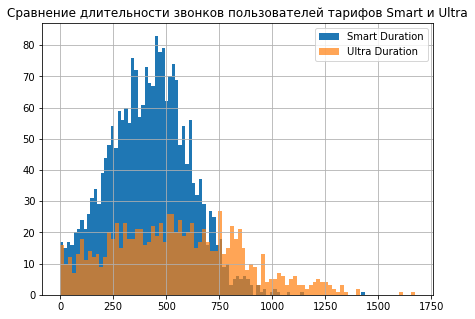

In [367]:
# построим гистограммы для длительности звонков
final_data[final_data['tariff_name'] =='smart']['duration'].hist(bins = 90, label = 'Smart Duration', figsize = (7,5))
final_data[final_data['tariff_name'] =='ultra']['duration'].hist(bins = 90, alpha = 0.7, label = 'Ultra Duration')
plt.title('Сравнение длительности звонков пользователей тарифов Smart и Ultra')
plt.legend()

<b>ВЫВОД:</b> гистограмма длительности звонков пользователей тарифа smart являет собой нормальное распределение с четким пиком в середине и снижением по краям.
Гистограмма длительности звонков пользователей тарифа ultra стремится к нормальному, но не унимодально и сильно скошено вправо.
В случае тарифа ultra можно говорить об аномально больших значениях продолжительности звонков - выбросах, влияющих на скос.
Пропускают звонки пользователи обоих тарифов примерно одинаково часто.

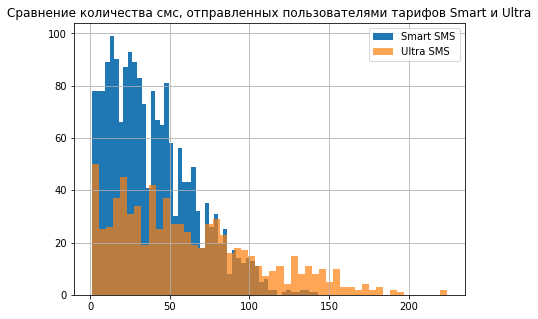

In [368]:
# построим гистограммы для количества смс
final_data[final_data['tariff_name'] =='smart']['message_count'].hist(bins = 50, label = 'Smart SMS', figsize = (7,5))
final_data[final_data['tariff_name'] =='ultra']['message_count'].hist(bins = 50, alpha = 0.7, label = 'Ultra SMS')
plt.title('Сравнение количества смс, отправленных пользователями тарифов Smart и Ultra')
plt.legend()

<b>ВЫВОД:</b> в обоих случаях гистограммы вытянуты вправо. При этом наблюдается тенденция к поступательному снижению - вероятность получить пользователя, отправляющего больше смс снижается пропорционально количеству.

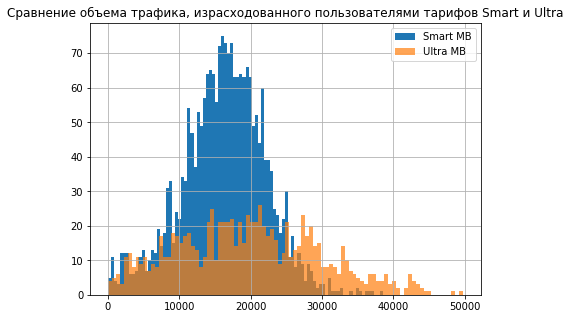

In [369]:
# построим гистограммы для трафика
final_data[final_data['tariff_name'] =='smart']['mb_used'].hist(bins = 90, label = 'Smart MB', figsize = (7,5))
final_data[final_data['tariff_name'] =='ultra']['mb_used'].hist(bins = 90, alpha = 0.7, label = 'Ultra MB')
plt.title('Сравнение объема трафика, израсходованного пользователями тарифов Smart и Ultra')
plt.legend()

<b>ВЫВОД:</b> в случае клиентов тарифа smart наблюдается нормальное распределение с четким пиком посередине. В случае пользователей ultra распределение нормальное, но более сглаженное. При этом, судя по графику, пользователи smart чаще превышают месячный лимит тарифа по сравнению с пользователями ultra.

## Статистическая проверка гипотез

### Проверка гипотезы: "средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются".

- Н0: средняя выручка пользователей ultra равна средней выручке польз. smart
- H1: средняя выручка пользователей ultra не равна средней выручке пользователей smart 

In [370]:
# заполним пропуски нулями, т.к. тест не обработает пропуски
smart_users = final_data[final_data['tariff_name'] =='smart'].fillna(0)
ultra_users = final_data[final_data['tariff_name'] =='ultra'].fillna(0)

In [371]:
# проведем тест на равенство средних двух выборок
alpha = 0.05
results = st.ttest_ind(smart_users['total_revenue'], ultra_users['total_revenue'], equal_var = False)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Можно отвергнуть нулевую гипотезу') 
    if results.pvalue / 2 < alpha and smart_users['total_revenue'].mean() < ultra_users['total_revenue'].mean():
        print('Выручка по тарифу ultra больше')
    else:
        print('Выручка по тарифу smart больше')
else:
    print('Нельзя отвергнуть гипотезу')

p-значение:  5.138306503578729e-47
Можно отвергнуть нулевую гипотезу
Выручка по тарифу ultra больше


<b>ВЫВОД:</b> первая гипотеза подтвердилась. Выручка по тарифам различается. 

### Проверка гипотезы "средняя выручка пользователей из Москвы отличается от средней выручки по другим регионам".

In [375]:
# возьмем нужные срезы из датасета 
moscow_users = final_data.query('city == "Москва"').fillna(0)
other_users = final_data.query('city != "Москва"').fillna(0)

In [376]:
# проведем тест сравнения для двух совокупностей
alpha = 0.05
results = st.ttest_ind(moscow_users['total_revenue'], other_users['total_revenue'])
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Можно отвергнуть нулевую гипотезу, выручка по регионам различается')
else:
    print('Нельзя отвергнуть нулевую гипотезу')

p-значение:  0.9290050577097656
Нельзя отвергнуть нулевую гипотезу


<b>ВЫВОД:</b> гипотеза не подтвердилась. Что москвичи, что пользователи других городов и регионов, приносят одинаковую прибыль.

## Общий вывод:
- в ходе исследования подтвердилась гипотеза о том, что выручка по тарифам различается, при этом выручка с тарифа ultra превышает выручку с тарифа smart. Следует отметить, что это при том, что пользователей ultra более чем в два раза меньше по сравнению с пользователями smart. Значит, фиксированный больший размер абонентской платы все же превышает дополнительные расходы за лишние трафик и звонки.
- вторая гипотеза не подтвердилась. Неважно, в каком регионе обитает пользователь - количество денег, полученное с него примерно одинаковое.